# Experimentation for nlp hw1

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from speech import *
import numpy as np
from tqdm import tqdm
from supervised_experiments import *
from unsupervised_experiments import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
fname = "speech.tar.gz"

### General submission code - Supervised

In [5]:
data = Data(fname)
data.preprocess(feat_list['cv_nltk_lemma'],
                svd = TruncatedSVD(n_components = 2500))
clf = LogisticRegression(solver = "lbfgs", penalty = 'l2')
clf.fit(data.train_x, data.train_y)

# Train performance
preds = clf.predict(data.val_x)
train_acc = accuracy_score(clf.predict(data.train_x), data.train_y)

#Val performance
val_acc =  accuracy_score(data.val_y, preds)
ic(val_acc)


# ic("Reading unlabeled data")
# unlabeled = read_unlabeled("data/" + fname, data, preprocess = True)
# print("Writing pred file")
# write_pred_kaggle_file(unlabeled, clf, "speech-pred.csv", data)


ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414
ic| val_acc: 0.4420289855072464


0.4420289855072464

### General submission code - Semi-supervised

In [8]:
model = 'word2vec_60ul.model'
data_ssup = Data(fname)
data_ssup.preprocess(feat_list['cv_nltk_lemma'],
                svd = TruncatedSVD(n_components = 2500))
clf = LogisticRegression(solver = "lbfgs", penalty = 'l2')
model = Word2Vec.load("models/" + model)
w2v = W2V_Vectorizer(model)
data_ssup.train_x_unlabeled = np.array(w2v_build_dataset(w2v,SamsTokenizer(), data_ssup.train_data))
data_ssup.val_x_unlabeled = np.array(w2v_build_dataset(w2v, SamsTokenizer(), data_ssup.val_data))

data_ssup.train_x_final = np.hstack((data_ssup.train_x, data_ssup.train_x_unlabeled))
data_ssup.val_x_final = np.hstack((data_ssup.val_x, data_ssup.val_x_unlabeled))
clf.fit(data_ssup.train_x_final, data_ssup.train_y)

# Train performance
preds_ssup = clf.predict(data_ssup.val_x_final)
train_acc = accuracy_score(clf.predict(data_ssup.train_x_final), data_ssup.train_y)

#Val performance
val_acc =  accuracy_score(data_ssup.val_y, preds_ssup)
ic(val_acc)

# ic("Reading unlabeled data")
# unlabeled = read_unlabeled_w2v("data/" + fname, data_ssup, W2V_Vectorizer(model))
# print("Writing pred file")
# write_pred_kaggle_file(unlabeled, clf, "speech-pred-unlabeled.csv", data_ssup)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414
ic| val_acc: 0.45652173913043476


0.45652173913043476

### Exploration of where unlabeled data helped in validation set

In [9]:
# Examples where unlabeled data hurt
labeled_better = (preds == data.val_y) & (preds_ssup != data_ssup.val_y) 

# Examples where unlabeled data hurt
unlabeled_better = (preds != data.val_y) & (preds_ssup == data_ssup.val_y) 

In [19]:
data.__dict__.keys()

dict_keys(['featurization', 'norm', 'count_vect', 'le', 'svd', 'filename', 'train_data', 'train_fnames', 'train_labels', 'val_data', 'val_fnames', 'val_labels', 'train_x', 'val_x', 'target_labels', 'train_y', 'val_y'])

In [11]:
np.argwhere(labeled_better == 1)

array([[ 30],
       [ 33],
       [ 58],
       [183],
       [186],
       [285],
       [373],
       [393]])

In [61]:
idx = 186
print(data.val_data[idx], data.le.inverse_transform([preds[idx]]), 
                        data.le.inverse_transform([preds_ssup[idx]]), 
                        data.le.inverse_transform([data.val_y[idx]]))

b'come out of their comatose "Re-elect Obama" stance and ask the following question: How does the president think we discovered the natural' ['GINGRICH_PRIMARY2012'] ['CLINTON_PRIMARY2008'] ['GINGRICH_PRIMARY2012']


In [12]:
np.argwhere(unlabeled_better == 1)

array([[  5],
       [ 11],
       [ 36],
       [ 65],
       [ 83],
       [ 85],
       [116],
       [142],
       [160],
       [182],
       [197],
       [248],
       [327],
       [388]])

In [70]:
idx = 5
print(data.val_data[idx], data.le.inverse_transform([preds[idx]]), 
                        data.le.inverse_transform([preds_ssup[idx]]), 
                        data.le.inverse_transform([data.val_y[idx]]))
print(preds_ssup[idx])
print(preds[idx])

b"leadership of the Pennsylvania AFL-CIO is legendary. When Bill asks what time is it, we all know the answer: it's union time. Because" ['OBAMA_PRIMARY2008'] ['CLINTON_PRIMARY2008'] ['CLINTON_PRIMARY2008']
3
10


### Plotting embeddings with PCA for each candidate

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)
embeddings = data_ssup.val_x_final
res = pca.fit_transform(embeddings)

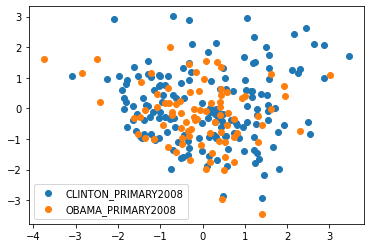

In [78]:
for i in list([3,10]):
    plt.scatter(res[preds_ssup == i,0], res[preds_ssup == i,1],label = data.le.inverse_transform([i])[0])

plt.legend()

In [96]:
ob = list(zip(*model.wv.most_similar('obama', topn = 100)))[0]

In [95]:
clin = list(zip(*model.wv.most_similar('clinton', topn = 100)))[0]

In [102]:
obama_special = list(set(ob) - set(clin))
# print(len(obama_special))
obama_special[:20]

51


['freedom.president',
 'november.john',
 'tony',
 'reportedly',
 're-introduced',
 'trickle-down',
 'bush.john',
 'scowcroft',
 'politico',
 'foreigner',
 'judges.',
 'clinton',
 'reagan',
 'presidential',
 'elected',
 'multiplying',
 '“',
 'eyesight',
 'bachmann',
 'ronald']

In [103]:
clinton_special = list(set(clin) - set(ob))
clinton_special[:20]

51


['bob',
 'congratulate',
 'newsday',
 'thompson',
 'bubba',
 'mayor',
 'chants',
 'interrupted',
 'suggesting',
 'mike',
 'applause',
 '1991',
 'dr.',
 'unintelligible',
 '...',
 'tim',
 'disenfranchised',
 'off-mike',
 'obama',
 'teleprompter']

## Supervised Experiments

### Initial exploration

In [38]:
fname = "speech.tar.gz"
preprocessors = [
    CountVectorizer(lowercase = False, tokenizer = SamsTokenizer(punct = True,lower = False)),
    CountVectorizer(tokenizer = SamsTokenizer(punct = True)),
    CountVectorizer(tokenizer = SamsTokenizer()),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer()),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 2),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 3),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 4),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 5),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 6),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 7),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 8),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 9),
    CountVectorizer(stop_words="english", tokenizer = SamsTokenizer(), min_df = 10),
]

d = dimensionality_exploration(fname, preprocessors)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


In [39]:
# d => [7878, 7414, 7028, 6762, 3602, 2561, 1996, 1653, 1412, 1245, 1124, 996, 890]

[7878, 7028, 7028, 6762, 3602, 2561, 1996, 1653, 1412, 1245, 1124, 996, 890]

([<matplotlib.axis.XTick at 0x7ff7c38c0f40>,
 [Text(0, 0, 'regex-\nsep'),
  Text(1, 0, 'case'),
  Text(2, 0, 'punct'),
  Text(3, 0, 'stopW +\nlemma'),
  Text(4, 0, 'min_df\n=2'),
  Text(5, 0, 'min_df\n=3'),
  Text(6, 0, 'min_df\n=4'),
  Text(7, 0, 'min_df\n=5'),
  Text(8, 0, 'min_df\n=6'),
  Text(9, 0, 'min_df\n=7'),
  Text(10, 0, 'min_df\n=8'),
  Text(11, 0, 'min_df\n=9'),
  Text(12, 0, 'min_df\n=10')])

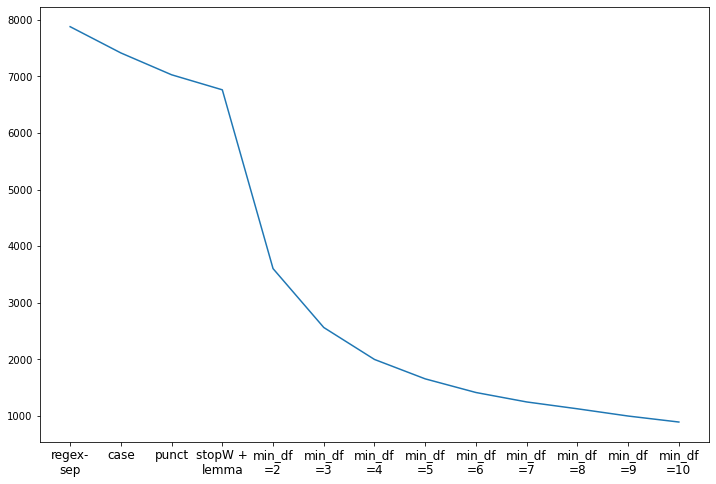

In [79]:
dim = [7878, 7414, 7028, 6762, 3602, 2561, 1996, 1653, 1412, 1245, 1124, 996, 890]
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(range(len(dim)), dim)
labels = ['regex-\nsep', 'case','punct','stopW +\nlemma','min_df\n=2','min_df\n=3','min_df\n=4','min_df\n=5','min_df\n=6','min_df\n=7','min_df\n=8','min_df\n=9','min_df\n=10']
plt.xticks(range(len(dim)), labels, fontsize = 12)

### Feature ablation

In [4]:
fname = "speech.tar.gz"

feat_list = {
    #CountVectorization
    "cv_nltk_case_punct":CountVectorizer(tokenizer = SamsTokenizer(tokenizer = "nltk", lower = False, punct = True, lemma = False)),
    "cv_cv_case_punct":CountVectorizer(tokenizer = SamsTokenizer(tokenizer = "cv", lower = False, punct = True, lemma = False)),
    "cv_nltk":CountVectorizer(tokenizer = SamsTokenizer(tokenizer = 'nltk', lemma = False)),
    "cv_cv": CountVectorizer(tokenizer = SamsTokenizer(lemma = False)),
    "cv_nltk_lemma":CountVectorizer(tokenizer = SamsTokenizer(tokenizer = 'nltk', lemma = True)),
    "cv_cv_lemma": CountVectorizer(tokenizer = SamsTokenizer(lemma = True)),
    "cv_nltk_lemma_stopw": CountVectorizer(stop_words = "english", tokenizer = SamsTokenizer(tokenizer = "nltk")),
    "cv_cv_lemma_stopw": CountVectorizer(stop_words = "english", tokenizer = SamsTokenizer(tokenizer = "cv")),

    #Tfidf vectorization
    "tfidf_nltk_case_punct":TfidfVectorizer(tokenizer = SamsTokenizer(tokenizer = "nltk", lower = False, punct = True, lemma = False)),
    "tfidf_cv_case_punct":TfidfVectorizer(tokenizer = SamsTokenizer(tokenizer = "cv", lower = False, punct = True, lemma = False)),
    "tfidf_nltk":TfidfVectorizer(tokenizer = SamsTokenizer(tokenizer = 'nltk', lemma = False)),
    "tfidf_cv": TfidfVectorizer(tokenizer = SamsTokenizer(lemma = False)),
    "tfidf_nltk_lemma":TfidfVectorizer(tokenizer = SamsTokenizer(tokenizer = 'nltk', lemma = True)),
    "tfidf_cv_lemma": TfidfVectorizer(tokenizer = SamsTokenizer(lemma = True)),
    "tfidf_nltk_lemma_stopw": TfidfVectorizer(stop_words = "english", tokenizer = SamsTokenizer(tokenizer = "nltk")),
    "tfidf_cv_lemma_stopw": TfidfVectorizer(stop_words = "english", tokenizer = SamsTokenizer(tokenizer = "cv")),
}

In [ ]:
a1 = feature_ablation(fname, feat_list)

In [6]:
a1

{'cv_case_punct_nltk': 0.43719806763285024,
 'cv_case_punct_cv': 0.3961352657004831,
 'cv_nltk': 0.43478260869565216,
 'cv_cv': 0.41304347826086957,
 'cv_nltk_lemma': 0.43478260869565216,
 'cv_cv_lemma': 0.41304347826086957,
 'cv_nltk_lemma_stopw': 0.40096618357487923,
 'cv_cv_lemma_stopw': 0.39855072463768115,
 'tfidf_case_punct_nltk': 0.38164251207729466,
 'tfidf_case_punct_cv': 0.35990338164251207,
 'tfidf_nltk': 0.38164251207729466,
 'tfidf_cv': 0.3743961352657005,
 'tfidf_nltk_lemma': 0.38164251207729466,
 'tfidf_cv_lemma': 0.3743961352657005,
 'tfidf_nltk_lemma_stopw': 0.3864734299516908,
 'tfidf_cv_lemma_stopw': 0.38164251207729466}

### Dimensionality Ablation

In [15]:
data = Data(fname)
data.preprocess(feat_list["cv_nltk_lemma"], norm = True)
print(data.train_x.shape)
print(data.val_x.shape)
# sys.exit(1)
comp_list = [100,500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
a2 = dimensionality_ablation(data, comp_list)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


(4370, 7689)
(414, 7689)


In [16]:
a2

{100: 0.2826086956521739,
 500: 0.32367149758454106,
 1000: 0.3309178743961353,
 1500: 0.33816425120772947,
 2000: 0.33816425120772947,
 2500: 0.34057971014492755,
 3000: 0.33816425120772947,
 4000: 0.34057971014492755,
 5000: 0.33816425120772947}

In [17]:
data = Data(fname)
data.preprocess(feat_list["cv_nltk_lemma"], norm = False)
print(data.train_x.shape)
print(data.val_x.shape)
# sys.exit(1)
comp_list = [100,500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
a2_2 = dimensionality_ablation(data, comp_list)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


(4370, 7689)
(414, 7689)


In [18]:
a2_2

{100: 0.2971014492753623,
 500: 0.38405797101449274,
 1000: 0.4227053140096618,
 1500: 0.42995169082125606,
 2000: 0.43478260869565216,
 2500: 0.43719806763285024,
 3000: 0.4323671497584541,
 4000: 0.43719806763285024,
 5000: 0.43719806763285024}

In [67]:
a2 = {100: 0.2826086956521739,
 500: 0.32367149758454106,
 1000: 0.3309178743961353,
 1500: 0.33816425120772947,
 2000: 0.33816425120772947,
 2500: 0.34057971014492755,
 3000: 0.33816425120772947,
 4000: 0.34057971014492755,
 5000: 0.33816425120772947}

a2_2 = {100: 0.2971014492753623,
 500: 0.38405797101449274,
 1000: 0.4227053140096618,
 1500: 0.42995169082125606,
 2000: 0.43478260869565216,
 2500: 0.43719806763285024,
 3000: 0.4323671497584541,
 4000: 0.43719806763285024,
 5000: 0.43719806763285024}

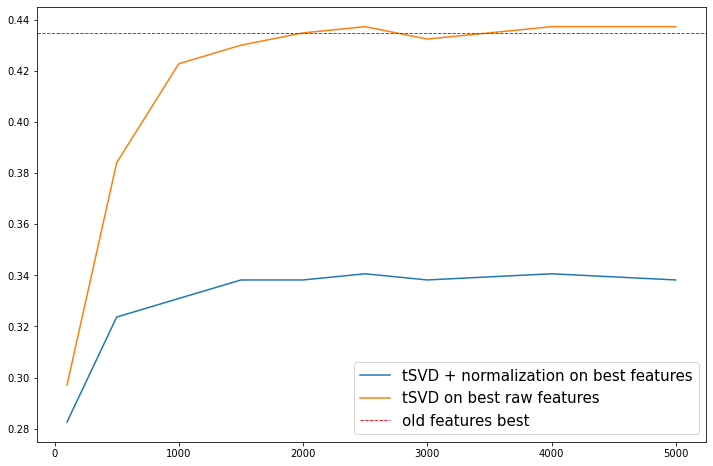

In [72]:
plt.figure(figsize=(12,8))
plt.plot(a2.keys(), a2.values(), label = "tSVD + normalization on best features")
plt.plot(a2.keys(), a2_2.values(), label = "tSVD on best raw features")
plt.axhline(0.4348,linestyle = 'dashed',linewidth = 0.9
            , c = 'red', label = "old features best")
plt.legend(fontsize = 15)

### Model ablation

In [4]:
data = Data(fname)
data.preprocess(feat_list["cv_nltk_lemma"], norm = False)
svd = TruncatedSVD(n_components = 2500)
data.train_x = svd.fit_transform(data.train_x)
data.val_x = svd.transform(data.val_x)
solvers = ["lbfgs", "liblinear", "saga", "newton-cg", "sag"]
penalties = ["l1", "l2", 'none']
a3 = solver_pen_ablation(data.train_x, data.train_y, data.val_x, data.val_y, solvers, penalties)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
penalty='none' is not supported for the liblinear solver
Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


In [5]:
a3

{'l1': {'lbfgs': '-',
  'liblinear': 0.4227053140096618,
  'saga': 0.427536231884058,
  'newton-cg': '-',
  'sag': '-'},
 'l2': {'lbfgs': 0.4468599033816425,
  'liblinear': 0.4323671497584541,
  'saga': 0.4468599033816425,
  'newton-cg': 0.4492753623188406,
  'sag': 0.4492753623188406},
 'none': {'lbfgs': 0.39855072463768115,
  'liblinear': '-',
  'saga': 0.45410628019323673,
  'newton-cg': 0.40096618357487923,
  'sag': 0.4468599033816425}}

### Vocabulary Plots

In [4]:
speech = Data(fname)
speech.count_vect = CountVectorizer(stop_words = "english")#, tokenizer = LemmaTokenizer())
cv2 =CountVectorizer()#, tokenizer = LemmaTokenizer())
matrix = speech.count_vect.fit_transform(speech.train_data)
matrix2 = cv2.fit_transform(speech.train_data)
print(matrix.shape)
freqs = zip(speech.count_vect.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
vocabulary_sorted = sorted(freqs, key=lambda x: -x[1])
freqs2 = zip(cv2.get_feature_names(), matrix2.sum(axis=0).tolist()[0])    
# sort from largest to smallest
vocabulary_sorted2 = sorted(freqs2, key=lambda x: -x[1])
print(type(vocabulary_sorted))

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


(4370, 7645)
<class 'list'>


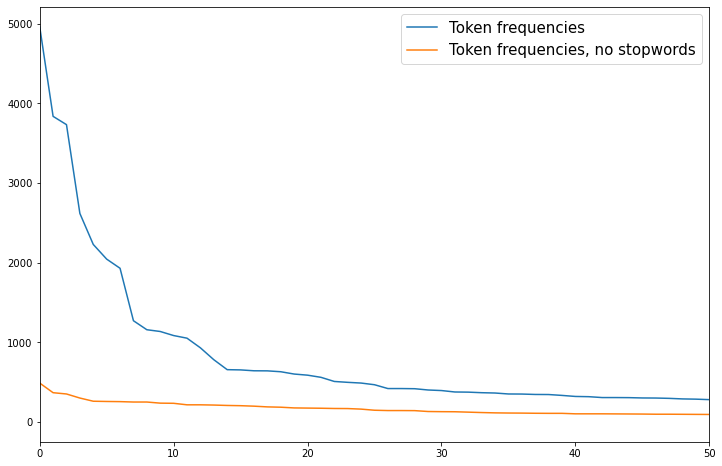

In [5]:
# Without stopwords
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(range(len(vocabulary_sorted2)), [item[1] for item in vocabulary_sorted2], label = "Token frequencies")
plt.plot(range(len(vocabulary_sorted)), [item[1] for item in vocabulary_sorted], label = "Token frequencies, no stopwords")
plt.xlim(0,50)
plt.legend(fontsize = 15)

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer as lemmatizer
lemmatizer = lemmatizer()
voc_l = [lemmatizer.lemmatize(i[0]) for i in vocabulary_sorted]
print(len(list(set(voc_l))))


6789


## Unsupervised experiments

### Vectorize input in preparation for Word2Vec

In [68]:
data = read_unlabeled("data/" + 
                      fname, None)

In [69]:
print(len(data.data))
# print(data.data[0])

43342


In [76]:
tokenizer = CountVectorizer(stop_words = "english",
                            tokenizer = SamsTokenizer(),
                           )
                            
def sentence_parser(sentences,tokenizer):
    res_sentences = []
    
    for s in tqdm(sentences):
        res_sentences.append(tokenizer(s))
    return res_sentences
    

In [77]:
data.parsed_unlabeled_data = sentence_parser(data.data, 
                                SamsTokenizer())

100%|██████████| 43342/43342 [00:23<00:00, 1811.10it/s]


In [84]:
labeled_data = Data(fname)
data.parsed_labeled_data = sentence_parser(labeled_data.train_data, 
                                           SamsTokenizer())
                                           

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414
100%|██████████| 4370/4370 [00:02<00:00, 1892.89it/s]


In [85]:
data.full_parsed_data = data.parsed_labeled_data + data.parsed_unlabeled_data

### Make embedding models

In [106]:
from gensim.models import Word2Vec

# for i in range(1,11):
#     l = len(data.parsed_unlabeled_data)
#     data.full_parsed_data = data.parsed_labeled_data +\
#     data.parsed_unlabeled_data[:(l//10)*i]
#     print(len(data.full_parsed_data))
#     model = Word2Vec(sentences=data.full_parsed_data,
#                  size=300,
#                  window=5,
#                  min_count=1, workers=1)
#     model.save("models/word2vec_" + str(i*10) + "ul.model")



model = Word2Vec.load('models/word2vec_100ul.model')

### Visualize Embeddings

In [98]:
test = ['health', 'care', 'healthcare', 'war', 'soldier', 'afghanistan',
        'iraq','gun','bear', 'clinton','mccain', 'terrorism', 'control',
        'obama','budget','money','9/11','quality', 'candidate']

embeddings = [model[i] for i in test]

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

res = pca.fit_transform(embeddings)

(19,) (19,)


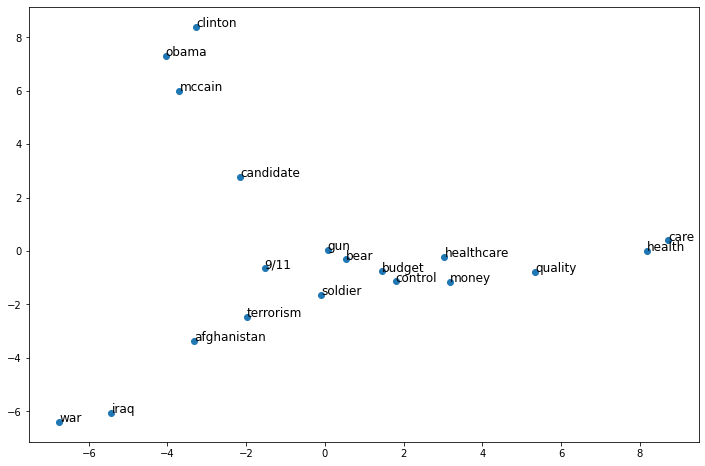

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize =(12,8))
print(res[:,0].shape, res[:,1].shape)
plt.scatter(res[:,0].flatten(),res[:,1].flatten())
for i, text in enumerate(test):
    plt.annotate(text, (res[i,0],res[i,1]), fontsize = 12)

### Run experiment with Word2Vec

In [3]:
models = ['word2vec_{}ul.model'.format(i*10) for i in range(1,11)]
models

['word2vec_10ul.model',
 'word2vec_20ul.model',
 'word2vec_30ul.model',
 'word2vec_40ul.model',
 'word2vec_50ul.model',
 'word2vec_60ul.model',
 'word2vec_70ul.model',
 'word2vec_80ul.model',
 'word2vec_90ul.model',
 'word2vec_100ul.model']

In [105]:
w2v_ablation(models, fname, LogisticRegression)

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


[0.27294685990338163,
 0.2777777777777778,
 0.2753623188405797,
 0.30917874396135264,
 0.3115942028985507,
 0.3164251207729469,
 0.3164251207729469,
 0.32608695652173914,
 0.3309178743961353,
 0.32367149758454106]

### Adding back original features + word embeddings

In [ ]:
w2v_ablation_all_features(models, fname, LogisticRegression(solver = 'sag', penalty = 'l2'), feat_list['cv_nltk_lemma'], TruncatedSVD(n_components= 2500))

ic| '-- train data'
ic| member.name: 'train.tsv'
ic| len(self.train_data): 4370
ic| '-- val data'
ic| member.name: 'dev.tsv'
ic| len(self.val_data): 414


In [ ]:
# Lbfgs and SVD
lbfgs = [0.43478260869565216,
 0.4444444444444444,
 0.4468599033816425,
 0.45169082125603865,
 0.4492753623188406,
 0.45169082125603865,
 0.4492753623188406,
 0.4444444444444444,
 0.4492753623188406,
 0.4396135265700483]


no_extra = [0.27294685990338163,
 0.2777777777777778,
 0.2753623188405797,
 0.30917874396135264,
 0.3115942028985507,
 0.3164251207729469,
 0.3164251207729469,
 0.32608695652173914,
 0.3309178743961353,
 0.32367149758454106]
# SAG and SVD 2500


sag = [0.4420289855072464,
 0.4420289855072464,
 0.4468599033816425,
 0.45169082125603865,
 0.4492753623188406,
 0.45410628019323673,
 0.4492753623188406,
 0.4444444444444444,
 0.4444444444444444,
 0.4396135265700483]

In [2]:
import matplotlib.pyplot as plt

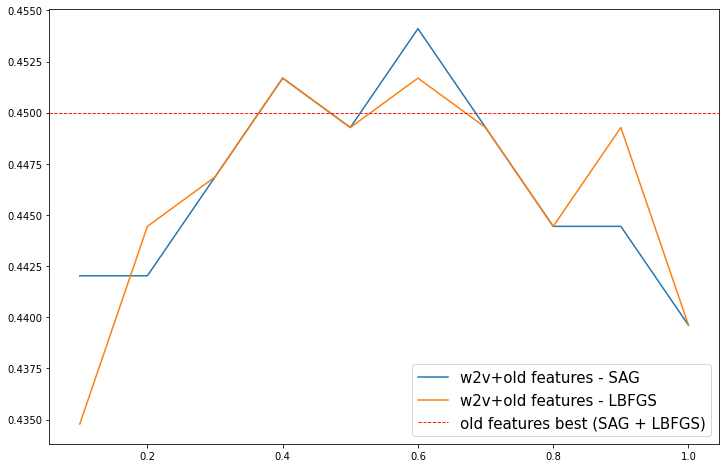

In [74]:
import numpy as np
x = np.arange(0.1,1.1, 0.1)
plt.figure(figsize = (12,8))
plt.plot(x, sag, label="w2v+old features - SAG")
plt.plot(x, lbfgs, label="w2v+old features - LBFGS")
# plt.plot(x, no_extra, label="w2v - LBFGS")
plt.axhline(0.450,linestyle = 'dashed',linewidth = 0.9
            , c = 'red', label = "old features best (SAG + LBFGS)")
plt.legend(fontsize = 15)